# <font color = blue>**Gesture Recognition Case Study**</font>

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

## <font color = blue>**Project Overview:**</font>

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a **sequence of 30 frames(images)**. These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 
 
Homogenous data will not be there. It will come from various source of different sizes like 360 * 360 and 120 * 160 pixels. So to utilize them we have to make them uniform in size.


## <font color = blue>**Goals of this Project:**</font>

Build a model to recognise 5 hand gestures. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

	• Thumbs up:  Increase the volume
	• Thumbs down: Decrease the volume
	• Left swipe: 'Jump' backwards 10 seconds
	• Right swipe: 'Jump' forward 10 seconds  
	• Stop: Pause the movie


We need to accomplish the following in the project:

   1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like **cropping, resizing and normalization** should be performed successfully.
   2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.
   3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [15]:
#Checking the GPU Configuration of system.

!nvidia-smi

Mon Oct 25 18:21:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:3D:00.0 Off |                  Off |
| 30%   27C    P8    17W / 300W |    397MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#import all required Python libaries
import numpy as np
import os
from imageio import imread
from skimage import io
from skimage.transform import resize
import datetime
import os
import pathlib
import PIL
import matplotlib.pyplot as plt

#Added to print data on current window screen
%matplotlib inline

#Added to avoid warning and not to display on notebook
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**base path: /home/datasets/Project_data**

In [3]:
base_path = '/home/datasets/Project_data/'
train_doc = np.random.permutation(open(base_path + 'train.csv').readlines())
val_doc = np.random.permutation(open(base_path + 'val.csv').readlines())
batch_size = 32 #experiment with the batch size

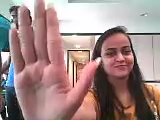

In [4]:
# Let's visualize one image first, to verify it is working or not.

sample_train_img_path = pathlib.Path(base_path + 'train/' + train_doc[10].split(';')[0])
sample_train_img = list(sample_train_img_path.glob("*"))
PIL.Image.open(str(sample_train_img[0]))

As the `train` and `val` directory has two shape of images `{(360, 360, 3), (120, 160, 3)}`. We need to reshape it to a constant size across all.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [j for j in range(0, 30)]
    x = len(img_idx)         #no_of_img
    y = 120                  #img_height
    z = 120                  #img_width
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Crop and Resizing of Image
                    #crop the image to (120, 120, 3), if the shape is (120, 160, 3)
                    #and resize to (120, 120, 3), if the shape is (360, 360, 3)
                    if image.shape[0] == 120:
                        # Image Crop
                        image = image[0:120, 0:120]
                    elif image.shape[0] == 360:
                        # Image Resize
                        image = resize(image, (120, 120))

                    #normalise                        
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        rem_data_points = len(t) - (num_batches * batch_size) # calculate the number of remaining data points
        
        if rem_data_points > 0:
            batch_data = np.zeros((rem_data_points,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_data_points,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(rem_data_points): # iterate over the remaining_data_points
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Crop and Resizing of Image
                    #crop the image to (120, 120, 3), if the shape is (120, 160, 3)
                    #and resize to (120, 120, 3), if the shape is (360, 360, 3)
                    if image.shape[0] == 120:
                        # Image Crop
                        image = resize(image, (120,120))
                    elif image.shape[0] == 360:
                        # Image Resize
                        image = resize(image, (120, 120))
                    
                    #normalise
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = base_path + 'train'
val_path = base_path + 'val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
#importing Keras libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

#Transfer Learning libraries
from tensorflow.keras.regularizers import L2
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB0

## ModelTrainer

A class whose purpose is to **initialize**, **train** and **plot** (the accuracy & the loss) for the model's train and validation history.

In [8]:
img_height = 120
img_width = 120
input_shape = (30, img_height, img_width, 3)
num_classes = 5  # There are Five different gestures which can be considered as classes.

### <font color="maroon">**Model 1: Conv2D + RNN using TimeDistributed with LSTM**</font>

In [24]:
#write your model here
model1 = Sequential()

# 1st Convolution Layer
model1.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

# 2nd Convolution Layer
model1.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

# 3rd Convolution Layer
model1.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

# 4th Convolution Layer
model1.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

# 5th Convolution Layer
model1.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

# FC layer
model1.add(TimeDistributed(Flatten()))

model1.add(LSTM(256, return_sequences=False))
model1.add(Dropout(0.5))

model1.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
#Creating a function which will display a model summary in detail
def compile_model(model):
    optimiser = 'adam' #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
def train_model(model):
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 2, cooldown = 1,  verbose = 1) # write the REducelronplateau code here
    ES = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)     #EarlyStop
    callbacks_list = [checkpoint, ES, LR]
    
    #The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    print("steps_per_epoch: ", steps_per_epoch)

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    print("validation_steps: ", validation_steps)
    
    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    
    model_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    return model_history

In [13]:
#Visualizing the results

def plot_model_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    #Display Maximum Training Accuracy
    print("=====================================================================================")
    print("Training Accuracy: ", round(max(history.history['categorical_accuracy'])*100,2))
    #Display Maximum Validation Accuracy
    print("Validation Accuracy: ", round(max(history.history['val_categorical_accuracy'])*100,2))
    print("=====================================================================================")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 15, 15, 64)   

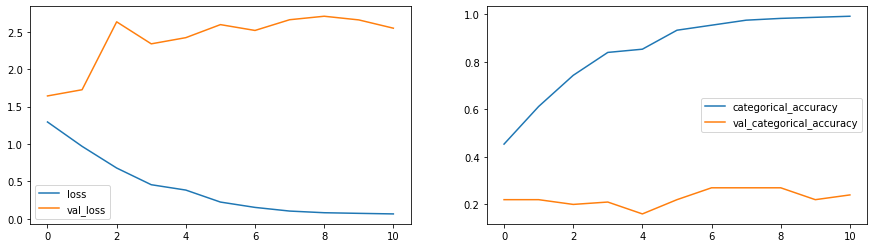

In [28]:
#Model 1 Build and Compile:
model1 = compile_model(model1)
print(model1.summary())

#Model 1 Train:
model_history1 = train_model(model1)

#Model 1 Plot:
plot_model_history(model_history1)

### Observation:
Model is having training and validation accuracy as 99% and 27% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 2: Conv2D + RNN using TimeDistributed with GRU**</font>

In [30]:
model2 = Sequential()

# 1st Convolution Layer
model2.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

# 2nd Convolution Layer
model2.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

# 3rd Convolution Layer
model2.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

# 4th Convolution Layer
model2.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

# 5th Convolution Layer
model2.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

# FC layer
model2.add(TimeDistributed(Flatten()))

model2.add(GRU(256, return_sequences=False))
model2.add(Dropout(0.5))

model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(num_classes, activation='softmax'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 30, 15, 15, 64)   

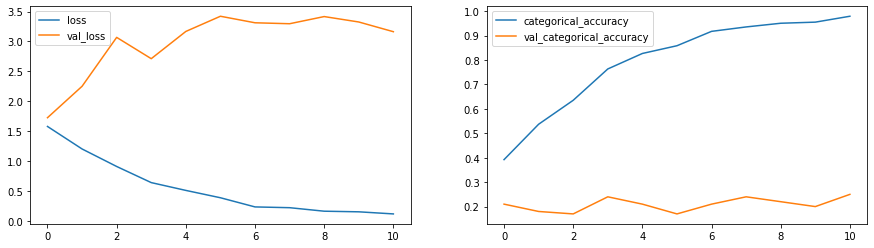

In [31]:
#Model 2 Build:
model2 = compile_model(model2)
print(model2.summary())

#Model 2 Train:
model_history2 = train_model(model2)

#Model 2 Plot:
plot_model_history(model_history2)

### Observation:
Model is having training and validation accuracy as 97% and 25% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 3: Conv3D along with MaxPooling3D and 4 Convolution Layers**</font>

In [34]:
model3 = Sequential()

# 1st Convolution Layer
model3.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Convolution Layer
model3.add(Conv3D(32, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Convolution Layer
model3.add(Conv3D(64, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 4th Convolution Layer
model3.add(Conv3D(128, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# FC layer
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(num_classes, activation='softmax'))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 15, 60, 60, 32)   

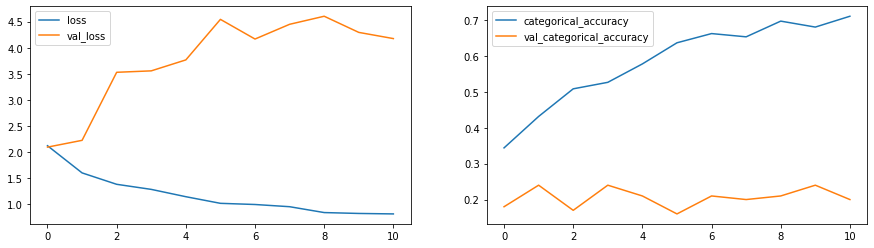

In [35]:
#Model 3 Build:
model3 = compile_model(model3)
print(model3.summary())

#Model 3 Train:
model_history3 = train_model(model3)

#Model 3 Plot:
plot_model_history(model_history3)

### Observation:
Model is having training and validation accuracy as 71% and 24% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 4: Conv3D along with MaxPooling3D and 5 Convolution Layers**</font>

In [36]:
model4 = Sequential()

# 1st Convolution Layer
model4.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Convolution Layer
model4.add(Conv3D(32, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Convolution Layer
model4.add(Conv3D(64, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 4th Convolution Layer
model4.add(Conv3D(128, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 5th Convolution Layer
model4.add(Conv3D(256, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
#model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# FC layer
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(128,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(num_classes, activation='softmax'))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 15, 60, 60, 32)   

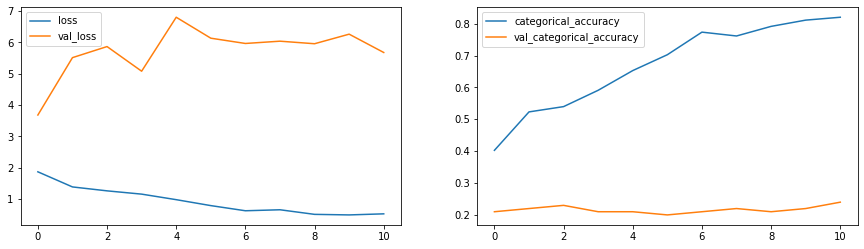

In [37]:
#Model 4 Build:
model4 = compile_model(model4)
print(model4.summary())

#Model 4 Train:
model_history4 = train_model(model4)

#Model 4 Plot:
plot_model_history(model_history4)

### Observation:
Model is having training and validation accuracy as 82% and 24% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 5: Adding MaxPooling3D after every two similar Conv3D Layers**</font>

In [38]:
model5 = Sequential()

# 1st Convolution Layer
model5.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Convolution Layer
model5.add(Conv3D(32, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(Conv3D(32, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Convolution Layer
model5.add(Conv3D(64, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(Conv3D(64, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 4th Convolution Layer
model5.add(Conv3D(128, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(Conv3D(128, (3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())

model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

# FC layer
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(64,activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(num_classes, activation='softmax'))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)   

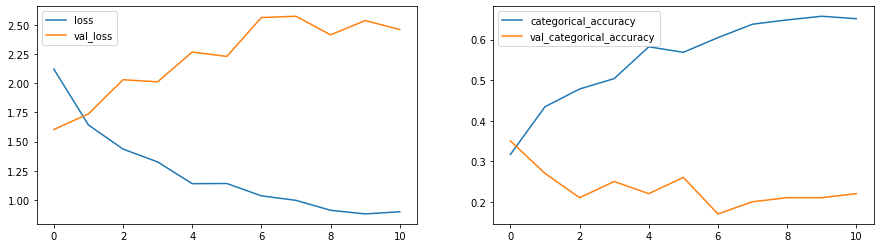

In [39]:
#Model 5 Build:
model5 = compile_model(model5)
print(model5.summary())

#Model 5 Train:
model_history5 = train_model(model5)

#Model 5 Plot:
plot_model_history(model_history5)

### Observation:
Model is having training and validation accuracy as 66% and 35% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 6: Adding Dropout after each Conv3D Layer**</font>

In [40]:
model6 = Sequential()

# 1st Convolution Layer
model6.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.5))

# 2nd Convolution Layer
model6.add(Conv3D(32, (3,3,3), padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.5))

# 3rd Convolution Layer
model6.add(Conv3D(64, (3,3,3), padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.5))

# 4th Convolution Layer
model6.add(Conv3D(128, (3,3,3), padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.5))

# FC layer
model6.add(Flatten())
model6.add(Dense(64, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))

model6.add(Dense(64,activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))

model6.add(Dense(num_classes, activation='softmax'))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)   

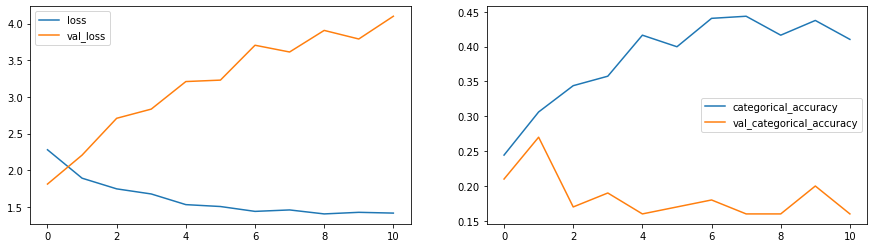

In [41]:
#Model 6 Build:
model6 = compile_model(model6)
print(model6.summary())

#Model 6 Train:
model_history6 = train_model(model6)

#Model 6 Plot:
plot_model_history(model_history6)

### Observation:
Model is having training and validation accuracy as 44% and 27% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 7: Adding L2 Regularizer in Fully Connected layer in Conv3D Network**</font>

In [42]:
model7 = Sequential()

# 1st Convolution Layer
model7.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model7.add(Activation('relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Convolution Layer
model7.add(Conv3D(32, (3,3,3), padding='same'))
model7.add(Activation('relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Convolution Layer
model7.add(Conv3D(64, (3,3,3), padding='same'))
model7.add(Activation('relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 4th Convolution Layer
model7.add(Conv3D(128, (3,3,3), padding='same'))
model7.add(Activation('relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

# FC layer
model7.add(Flatten())
model7.add(Dense(64, activation='relu', kernel_regularizer=L2(0.01)))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))

model7.add(Dense(64,activation='relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))

model7.add(Dense(num_classes, activation='softmax'))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 15, 60, 60, 32)   

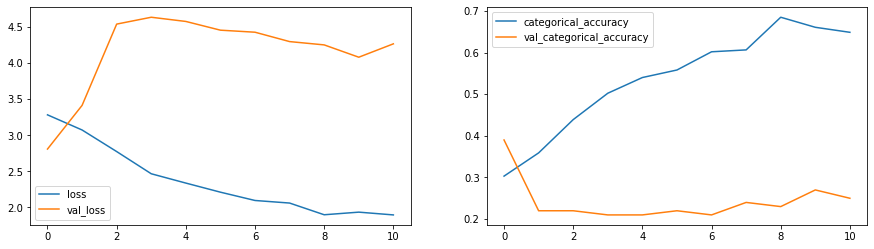

In [43]:
#Model 7 Build:
model7 = compile_model(model7)
print(model7.summary())

#Model 7 Train:
model_history7 = train_model(model7)

#Model 7 Plot:
plot_model_history(model_history7)

### Observation:
Model is having training and validation accuracy as 68% and 39% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 8: L2 Regularization, Adding MaxPooling3D after every two similar Conv3D Layers**</font>

In [44]:
model8 = Sequential()

# 1st Convolution Layer
model8.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Convolution Layer
model8.add(Conv3D(32, (3,3,3), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(Conv3D(32, (3,3,3), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Convolution Layer
model8.add(Conv3D(64, (3,3,3), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(Conv3D(64, (3,3,3), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 4th Convolution Layer
model8.add(Conv3D(128, (3,3,3), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(Conv3D(128, (3,3,3), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())

model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

# FC layer
model8.add(Flatten())
model8.add(Dense(64, activation='relu', kernel_regularizer=L2(0.01)))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))

model8.add(Dense(64,activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))

model8.add(Dense(num_classes, activation='softmax'))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_30 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 15, 60, 60, 16)  

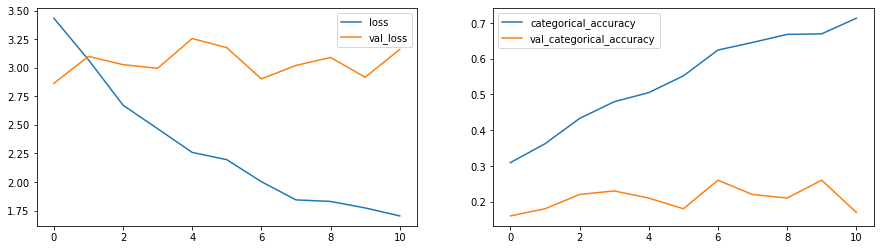

In [45]:
#Model 8 Build:
model8 = compile_model(model8)
print(model8.summary())

#Model 8 Train:
model_history8 = train_model(model8)

#Model 8 Plot:
plot_model_history(model_history8)

### Observation:
Model is having training and validation accuracy as 71% and 26% which shows model is overfitted and didn't learn't anything.

===================================================================================

### <font color="maroon">**Model 9: Adding more L2 Regularization along with MaxPooling3D after every two similar Conv3D Layers**</font>

In [46]:
model9 = Sequential()

# 1st Convolution Layer
model9.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model9.add(Activation('relu'))
model9.add(BatchNormalization())

model9.add(Conv3D(16, (3,3,3), padding='same', input_shape = input_shape))
model9.add(Activation('relu'))
model9.add(BatchNormalization())

model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Convolution Layer
model9.add(Conv3D(32, (3,3,3), padding='same'))
model9.add(Activation('relu'))
model9.add(BatchNormalization())

model9.add(Conv3D(32, (3,3,3), padding='same'))
model9.add(Activation('relu'))
model9.add(BatchNormalization())

model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Convolution Layer
model9.add(Conv3D(64, (3,3,3), padding='same'))
model9.add(Activation('relu'))
model9.add(BatchNormalization())

model9.add(Conv3D(64, (3,3,3), padding='same'))
model9.add(Activation('relu'))
model9.add(BatchNormalization())

model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

# FC layer
model9.add(Flatten())
model9.add(Dense(128, activation='relu', kernel_regularizer=L2(0.01)))
model9.add(BatchNormalization())
model9.add(Dropout(0.5))

model9.add(Dense(256,activation='relu', kernel_regularizer=L2(0.01)))
model9.add(BatchNormalization())
model9.add(Dropout(0.5))

model9.add(Dense(num_classes, activation='softmax'))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_38 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 15, 60, 60, 16)  

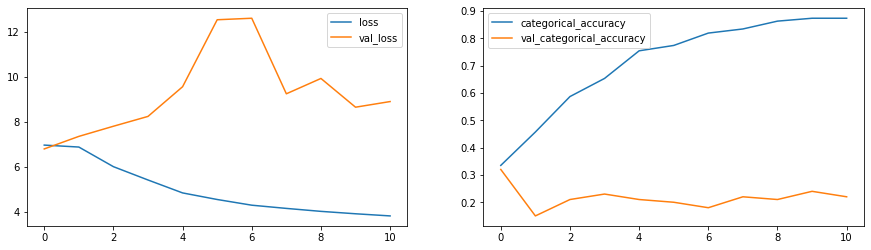

In [47]:
#Model 9 Build:
model9 = compile_model(model9)
print(model9.summary())

#Model 9 Train:
model_history9 = train_model(model9)

#Model 9 Plot:
plot_model_history(model_history9)

### Observation:
Model is having training and validation accuracy as 87% and 32% which shows model is overfitted and didn't learn't anything.

===================================================================================

### Transfer Learning

We will use some pre-trained models and try to use their knowledge to classify our cases correctly. 
These pre-trained models which are trained on millions of images may prove vital in solving our problem efficiently. 
For transfer learning we will be using below model:
- MobileNet

### <font color="maroon">**Model 10: Transfer Learning using MobileNet Model with LSTM**</font>

In [48]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
model10 = Sequential()
model10.add(TimeDistributed(mobilenet_transfer, input_shape = input_shape))

for layer in model10.layers:
    layer.trainable = False

model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((2, 2))))
model10.add(TimeDistributed(Flatten()))

model10.add(LSTM(64))
model10.add(Dropout(0.2))

model10.add(Dense(64, activation='relu'))
model10.add(Dropout(0.2))

model10.add(Dense(num_classes, activation='softmax'))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_64 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_65 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_66 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)              

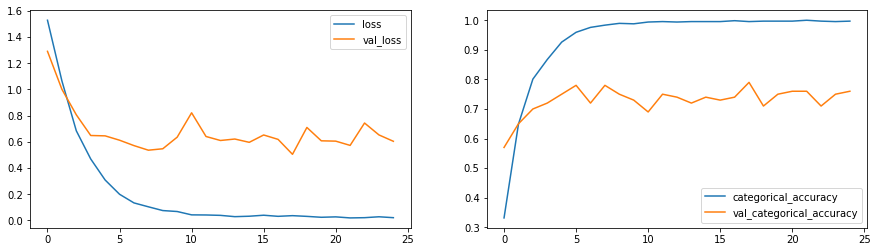

In [49]:
#Model 10 Build:
model10 = compile_model(model10)
print(model10.summary())

#Model 10 Train:
model_history10 = train_model(model10)

#Model 10 Plot:
plot_model_history(model_history10)

### Observation:
Model is having training and validation accuracy as 99% and 79% which shows model is good but can become better and able to learn the behaviour. So lets check with GRU as well.

===================================================================================

### <font color="maroon">**Model 11: Transfer Learning using MobileNet Model with GRU**</font>

In [14]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
model11 = Sequential()
model11.add(TimeDistributed(mobilenet_transfer, input_shape = input_shape))

model11.add(TimeDistributed(BatchNormalization()))
model11.add(TimeDistributed(MaxPooling2D((2, 2))))
model11.add(TimeDistributed(Flatten()))

model11.add(GRU(64))
model11.add(Dropout(0.2))

model11.add(Dense(64, activation='relu'))
model11.add(Dropout(0.2))

model11.add(Dense(num_classes, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

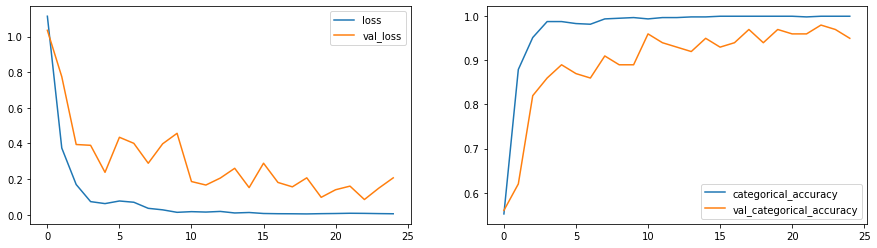

In [15]:
#Model 11 Build:
model11 = compile_model(model11)
print(model11.summary())

#Model 11 Train:
model_history11 = train_model(model11)

#Model 11 Plot:
plot_model_history(model_history11)

### Observation:
Model is having training and validation accuracy as 99% and 96% which shows model is Good model and able to learn the behaviour. So lets check with GRU as well.

===================================================================================

### Conclusion:

After all above model experiment, we are going to choose "Model 11 - Transfer Learning using MobileNet Model with GRU" as good model which performed well.

Number of Epoch = 25
Batch Size = 32
Number of parameters =  3,446,725

Best Model file: model-00022-0.00800-0.99849-0.16037-0.96000.h5